<a href="https://colab.research.google.com/github/jain-sasuke/Schrodinger-equation-using-PINN-for-hydrogen/blob/main/Schrodinger_for_hydrogen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

# Neural Network Definition
class SchrodingerNet(nn.Module):
    def __init__(self):
        super(SchrodingerNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Physics-Informed Hamiltonian Operator
def hamiltonian_operator(model, r, theta, phi, hbar=1.0, mu=1.0, e=1.0, epsilon_0=1.0):
    # Convert coordinates to require gradients for automatic differentiation
    r.requires_grad_(True)
    theta.requires_grad_(True)
    phi.requires_grad_(True)

    # Combine r, theta, and phi into a tensor
    coords = torch.stack([r, theta, phi], dim=1)

    # Predict the wavefunction using the neural network
    psi = model(coords)

    # Calculate the partial derivatives using autograd
    # First derivative with respect to r
    psi_r = autograd.grad(psi, r, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

    # Second derivative with respect to r
    psi_rr = autograd.grad(psi_r, r, grad_outputs=torch.ones_like(psi_r), create_graph=True)[0]

    # First derivative with respect to theta
    psi_theta = autograd.grad(psi, theta, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

    # Second derivative with respect to theta
    psi_theta_theta = autograd.grad(psi_theta, theta, grad_outputs=torch.ones_like(psi_theta), create_graph=True)[0]

    # First derivative with respect to phi
    psi_phi = autograd.grad(psi, phi, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

    # Second derivative with respect to phi
    psi_phi_phi = autograd.grad(psi_phi, phi, grad_outputs=torch.ones_like(psi_phi), create_graph=True)[0]

    # Compute the radial, angular theta, and angular phi components
    radial_term = -(hbar**2 / (2 * mu)) * (1 / r**2) * (r**2 * psi_rr)
    angular_theta_term = -(hbar**2 / (2 * mu)) * (1 / (r**2 * torch.sin(theta))) * (torch.sin(theta) * psi_theta_theta)
    angular_phi_term = -(hbar**2 / (2 * mu)) * (1 / (r**2 * torch.sin(theta)**2)) * psi_phi_phi

    # Compute the potential energy term
    potential_term = - e**2 / (4 * torch.pi * epsilon_0 * r)

    # Total Hamiltonian applied to the wavefunction
    hamiltonian_psi = radial_term + angular_theta_term + angular_phi_term + potential_term * psi

    return hamiltonian_psi

# Loss Function
def loss_function(model, r, theta, phi, E):
    hamiltonian_psi = hamiltonian_operator(model, r, theta, phi)
    coords = torch.stack([r, theta, phi], dim=1)
    psi_pred = model(coords)
    return torch.mean((hamiltonian_psi - E * psi_pred) ** 2)

# Function to sample spherical coordinates
def sample_coordinates(batch_size=100):
    r = torch.rand(batch_size) * 20.0  # r sampled from 0 to 20 (adjust as needed)
    theta = torch.rand(batch_size) * torch.pi  # theta sampled from 0 to π
    phi = torch.rand(batch_size) * 2 * torch.pi  # phi sampled from 0 to 2π
    return r, theta, phi

# Training Loop
def train_model(model, num_epochs=1000, learning_rate=0.001, batch_size=100, eigenvalue=-13.6):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Sample training points in spherical coordinates
        r, theta, phi = sample_coordinates(batch_size=batch_size)

        # Compute the loss
        loss = loss_function(model, r, theta, phi, eigenvalue)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Print the loss occasionally
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Main Script
if __name__ == "__main__":
    # Initialize the model
    model = SchrodingerNet()

    # Define the eigenvalue for the hydrogen atom (e.g., -13.6 eV for the ground state)
    eigenvalue = -13.6  # For n=1, in electron volts (you can change this)

    # Train the model
    train_model(model, num_epochs=1000, learning_rate=0.001, batch_size=100, eigenvalue=eigenvalue)


Epoch 0, Loss: 47.14921188354492
Epoch 100, Loss: 0.06318019330501556
Epoch 200, Loss: 0.013662147335708141
Epoch 300, Loss: 0.0070251114666461945
Epoch 400, Loss: 0.004421864170581102
Epoch 500, Loss: 0.0037812984082847834
Epoch 600, Loss: 0.002864519599825144
Epoch 700, Loss: 0.0024421096313744783
Epoch 800, Loss: 0.0029256450943648815
Epoch 900, Loss: 0.0020630364306271076


In [8]:
r_test = torch.tensor([0.0529])
theta_test = torch.tensor([torch.pi / 2])
phi_test = torch.tensor([torch.pi/2])

# Stack the test inputs
coords_test = torch.stack([r_test, theta_test, phi_test], dim=1)

# Predict the wavefunction using the trained model
psi_test = model(coords_test)
print(f"Predicted wavefunction value at (r, θ, φ) = (1.0, π/2, 0.0): {psi_test.item()}")


Predicted wavefunction value at (r, θ, φ) = (1.0, π/2, 0.0): 0.01765923947095871


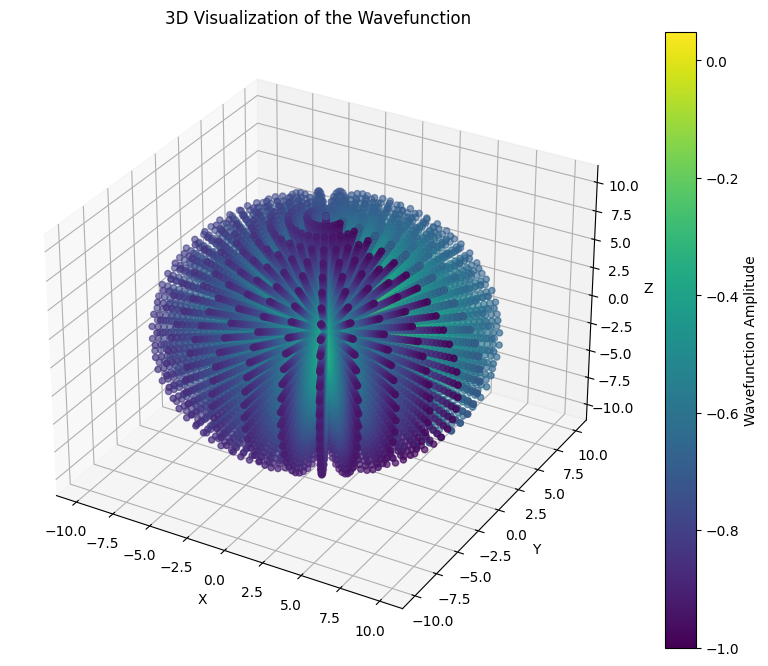

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to convert spherical coordinates to Cartesian coordinates
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

# Generate a grid of spherical coordinates
def generate_spherical_grid(num_points=30):
    r = torch.linspace(0.1, 10.0, num_points)  # r from 0.1 to 10 (adjust as needed)
    theta = torch.linspace(0, torch.pi, num_points)  # θ from 0 to π
    phi = torch.linspace(0, 2 * torch.pi, num_points)  # φ from 0 to 2π
    r, theta, phi = torch.meshgrid(r, theta, phi, indexing='ij')
    return r, theta, phi

# Generate and plot the wavefunction in 3D
def plot_wavefunction_3d(model):
    r, theta, phi = generate_spherical_grid(num_points=30)
    coords = torch.stack([r.flatten(), theta.flatten(), phi.flatten()], dim=1)  # Flatten for model input

    # Predict the wavefunction values
    psi_pred = model(coords).detach().numpy()  # Convert to NumPy for easier plotting

    # Convert spherical to Cartesian coordinates for 3D plotting
    r_np = r.flatten().numpy()
    theta_np = theta.flatten().numpy()
    phi_np = phi.flatten().numpy()
    x, y, z = spherical_to_cartesian(r_np, theta_np, phi_np)

    # Normalize the predicted wavefunction values for better visualization
    psi_pred_normalized = psi_pred / np.max(np.abs(psi_pred))

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=psi_pred_normalized, cmap='viridis', marker='o')
    fig.colorbar(scatter, ax=ax, label='Wavefunction Amplitude')

    ax.set_title("3D Visualization of the Wavefunction")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

# Main script to visualize the trained wavefunction
if __name__ == "__main__":
    # Assuming you have trained the model already
    model = SchrodingerNet()  # Replace with your trained model
    plot_wavefunction_3d(model)


Epoch 0, Loss: 7.65519380569458
Epoch 100, Loss: 0.005062914919108152
Epoch 200, Loss: 0.0011146091856062412
Epoch 300, Loss: 0.02880873717367649
Epoch 400, Loss: 0.012751723639667034
Epoch 500, Loss: 0.0026271757669746876
Epoch 600, Loss: 0.0010239002294838428
Epoch 700, Loss: 0.0007287999032996595
Epoch 800, Loss: 0.000517736712936312
Epoch 900, Loss: 0.000483313953736797


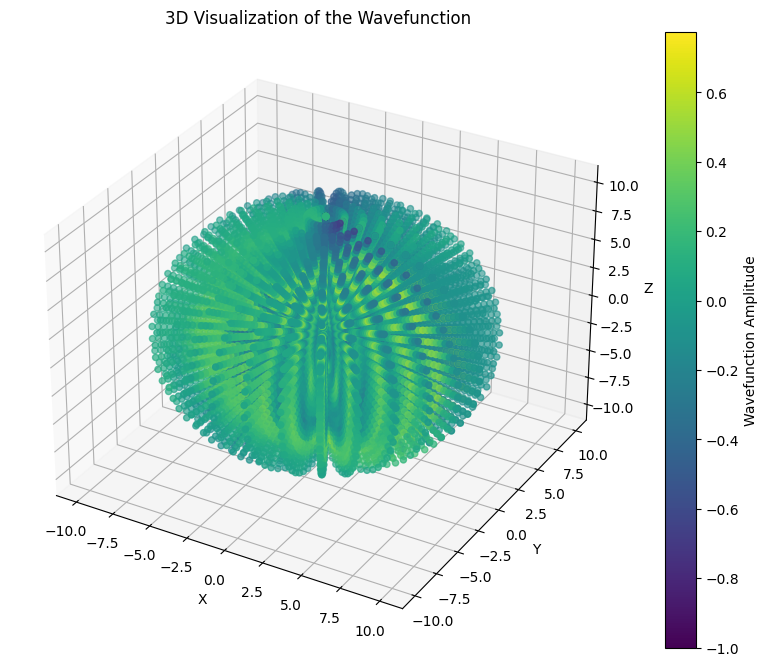

In [9]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Neural Network for the Wavefunction Approximation
class SchrodingerNet(nn.Module):
    def __init__(self):
        super(SchrodingerNet, self).__init__()
        self.fc1 = nn.Linear(3, 128)  # Input: r, theta, phi
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)  # Output: psi(r, theta, phi)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the Hamiltonian Operator
def hamiltonian_operator(model, r, theta, phi, hbar=1.0, mu=1.0, e=1.0, epsilon_0=1.0):
    # Convert coordinates to require gradients
    r.requires_grad_(True)
    theta.requires_grad_(True)
    phi.requires_grad_(True)

    # Combine r, theta, and phi into a tensor
    coords = torch.stack([r, theta, phi], dim=1)

    # Predict the wavefunction using the neural network
    psi = model(coords)

    # Calculate the derivatives using autograd
    psi_r = autograd.grad(psi, r, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    psi_rr = autograd.grad(psi_r, r, grad_outputs=torch.ones_like(psi_r), create_graph=True)[0]
    psi_theta = autograd.grad(psi, theta, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    psi_theta_theta = autograd.grad(psi_theta, theta, grad_outputs=torch.ones_like(psi_theta), create_graph=True)[0]
    psi_phi = autograd.grad(psi, phi, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    psi_phi_phi = autograd.grad(psi_phi, phi, grad_outputs=torch.ones_like(psi_phi), create_graph=True)[0]

    # Compute the terms of the Hamiltonian
    radial_term = -(hbar**2 / (2 * mu)) * (1 / r**2) * (r**2 * psi_rr)
    angular_theta_term = -(hbar**2 / (2 * mu)) * (1 / (r**2 * torch.sin(theta))) * (torch.sin(theta) * psi_theta_theta)
    angular_phi_term = -(hbar**2 / (2 * mu)) * (1 / (r**2 * torch.sin(theta)**2)) * psi_phi_phi
    potential_term = - e**2 / (4 * torch.pi * epsilon_0 * r)

    # Total Hamiltonian applied to the wavefunction
    hamiltonian_psi = radial_term + angular_theta_term + angular_phi_term + potential_term * psi
    return hamiltonian_psi

# Loss Function
def loss_function(model, r, theta, phi, E):
    hamiltonian_psi = hamiltonian_operator(model, r, theta, phi)
    coords = torch.stack([r, theta, phi], dim=1)
    psi_pred = model(coords)
    return torch.mean((hamiltonian_psi - E * psi_pred) ** 2)

# Function to sample spherical coordinates
def sample_coordinates(batch_size=100):
    r = torch.rand(batch_size) * 20.0  # r sampled from 0 to 20
    theta = torch.rand(batch_size) * torch.pi  # theta sampled from 0 to π
    phi = torch.rand(batch_size) * 2 * torch.pi  # phi sampled from 0 to 2π
    return r, theta, phi

# Training Loop
def train_model(model, num_epochs=1000, learning_rate=0.001, batch_size=100, eigenvalue=-13.6):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        r, theta, phi = sample_coordinates(batch_size=batch_size)
        loss = loss_function(model, r, theta, phi, eigenvalue)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Function to convert spherical coordinates to Cartesian coordinates
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

# Generate a grid of spherical coordinates for visualization
def generate_spherical_grid(num_points=30):
    r = torch.linspace(0.1, 10.0, num_points)
    theta = torch.linspace(0, torch.pi, num_points)
    phi = torch.linspace(0, 2 * torch.pi, num_points)
    r, theta, phi = torch.meshgrid(r, theta, phi, indexing='ij')
    return r, theta, phi

# Generate and plot the wavefunction in 3D
def plot_wavefunction_3d(model):
    r, theta, phi = generate_spherical_grid(num_points=30)
    coords = torch.stack([r.flatten(), theta.flatten(), phi.flatten()], dim=1)
    psi_pred = model(coords).detach().numpy()
    r_np = r.flatten().numpy()
    theta_np = theta.flatten().numpy()
    phi_np = phi.flatten().numpy()
    x, y, z = spherical_to_cartesian(r_np, theta_np, phi_np)
    psi_pred_normalized = psi_pred / np.max(np.abs(psi_pred))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=psi_pred_normalized, cmap='viridis', marker='o')
    fig.colorbar(scatter, ax=ax, label='Wavefunction Amplitude')
    ax.set_title("3D Visualization of the Wavefunction")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Main script
if __name__ == "__main__":
    # Initialize the model
    model = SchrodingerNet()

    # Define the eigenvalue for the hydrogen atom (ground state energy)
    eigenvalue = -13.6

    # Train the model
    train_model(model, num_epochs=1000, learning_rate=0.001, batch_size=100, eigenvalue=eigenvalue)

    # Visualize the trained wavefunction
    plot_wavefunction_3d(model)


Enter the eigenvalue (in eV, e.g., -13.6 for ground state): 0.85
Epoch 0, Loss: 0.044927094131708145
Epoch 100, Loss: 0.00010705460590543225
Epoch 200, Loss: 3.228981586289592e-05
Epoch 300, Loss: 0.0008031324250623584
Epoch 400, Loss: 0.0006641679792664945
Epoch 500, Loss: 0.04011708125472069
Epoch 600, Loss: 0.0027093158569186926
Epoch 700, Loss: 9.42729675443843e-05
Epoch 800, Loss: 9.403442163602449e-06
Epoch 900, Loss: 6.501765710709151e-06


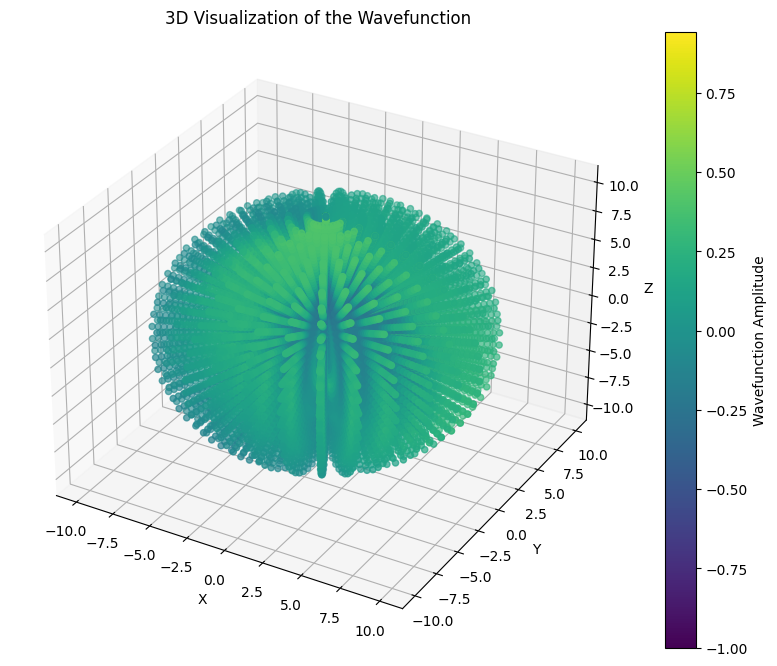

In [10]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Neural Network for the Wavefunction Approximation
class SchrodingerNet(nn.Module):
    def __init__(self):
        super(SchrodingerNet, self).__init__()
        self.fc1 = nn.Linear(3, 128)  # Input: r, theta, phi
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)  # Output: psi(r, theta, phi)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the Hamiltonian Operator
def hamiltonian_operator(model, r, theta, phi, hbar=1.0, mu=1.0, e=1.0, epsilon_0=1.0):
    # Convert coordinates to require gradients
    r.requires_grad_(True)
    theta.requires_grad_(True)
    phi.requires_grad_(True)

    # Combine r, theta, and phi into a tensor
    coords = torch.stack([r, theta, phi], dim=1)

    # Predict the wavefunction using the neural network
    psi = model(coords)

    # Calculate the derivatives using autograd
    psi_r = autograd.grad(psi, r, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    psi_rr = autograd.grad(psi_r, r, grad_outputs=torch.ones_like(psi_r), create_graph=True)[0]
    psi_theta = autograd.grad(psi, theta, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    psi_theta_theta = autograd.grad(psi_theta, theta, grad_outputs=torch.ones_like(psi_theta), create_graph=True)[0]
    psi_phi = autograd.grad(psi, phi, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    psi_phi_phi = autograd.grad(psi_phi, phi, grad_outputs=torch.ones_like(psi_phi), create_graph=True)[0]

    # Compute the terms of the Hamiltonian
    radial_term = -(hbar**2 / (2 * mu)) * (1 / r**2) * (r**2 * psi_rr)
    angular_theta_term = -(hbar**2 / (2 * mu)) * (1 / (r**2 * torch.sin(theta))) * (torch.sin(theta) * psi_theta_theta)
    angular_phi_term = -(hbar**2 / (2 * mu)) * (1 / (r**2 * torch.sin(theta)**2)) * psi_phi_phi
    potential_term = - e**2 / (4 * torch.pi * epsilon_0 * r)

    # Total Hamiltonian applied to the wavefunction
    hamiltonian_psi = radial_term + angular_theta_term + angular_phi_term + potential_term * psi
    return hamiltonian_psi

# Loss Function
def loss_function(model, r, theta, phi, E):
    hamiltonian_psi = hamiltonian_operator(model, r, theta, phi)
    coords = torch.stack([r, theta, phi], dim=1)
    psi_pred = model(coords)
    return torch.mean((hamiltonian_psi - E * psi_pred) ** 2)

# Function to sample spherical coordinates
def sample_coordinates(batch_size=100):
    r = torch.rand(batch_size) * 20.0  # r sampled from 0 to 20
    theta = torch.rand(batch_size) * torch.pi  # theta sampled from 0 to π
    phi = torch.rand(batch_size) * 2 * torch.pi  # phi sampled from 0 to 2π
    return r, theta, phi

# Training Loop
def train_model(model, eigenvalue, num_epochs=1000, learning_rate=0.001, batch_size=100):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        r, theta, phi = sample_coordinates(batch_size=batch_size)
        loss = loss_function(model, r, theta, phi, eigenvalue)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Function to convert spherical coordinates to Cartesian coordinates
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

# Generate a grid of spherical coordinates for visualization
def generate_spherical_grid(num_points=30):
    r = torch.linspace(0.1, 10.0, num_points)
    theta = torch.linspace(0, torch.pi, num_points)
    phi = torch.linspace(0, 2 * torch.pi, num_points)
    r, theta, phi = torch.meshgrid(r, theta, phi, indexing='ij')
    return r, theta, phi

# Generate and plot the wavefunction in 3D
def plot_wavefunction_3d(model):
    r, theta, phi = generate_spherical_grid(num_points=30)
    coords = torch.stack([r.flatten(), theta.flatten(), phi.flatten()], dim=1)
    psi_pred = model(coords).detach().numpy()
    r_np = r.flatten().numpy()
    theta_np = theta.flatten().numpy()
    phi_np = phi.flatten().numpy()
    x, y, z = spherical_to_cartesian(r_np, theta_np, phi_np)
    psi_pred_normalized = psi_pred / np.max(np.abs(psi_pred))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=psi_pred_normalized, cmap='viridis', marker='o')
    fig.colorbar(scatter, ax=ax, label='Wavefunction Amplitude')
    ax.set_title("3D Visualization of the Wavefunction")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Main function to input eigenvalue and visualize wavefunction
def main():
    # Input eigenvalue for the hydrogen atom (in eV)
    eigenvalue = float(input("Enter the eigenvalue (in eV, e.g., -13.6 for ground state): "))

    # Initialize the model
    model = SchrodingerNet()

    # Train the model with the given eigenvalue
    train_model(model, eigenvalue=eigenvalue, num_epochs=1000, learning_rate=0.001, batch_size=100)

    # Visualize the trained wavefunction
    plot_wavefunction_3d(model)

# Run the main function
if __name__ == "__main__":
    main()


Enter the eigenvalue (in eV, e.g., -13.6 for ground state): 0.85
Epoch 0, Loss: 0.006746387574821711
Epoch 100, Loss: 0.00017321715131402016
Epoch 200, Loss: 1.182553569378797e-05
Epoch 300, Loss: 1.1368510968168266e-05
Epoch 400, Loss: 0.0001800294703571126
Epoch 500, Loss: 0.045968104153871536
Epoch 600, Loss: 0.00016089675773400813
Epoch 700, Loss: 1.8518992874305695e-05
Epoch 800, Loss: 7.172605364758056e-06
Epoch 900, Loss: 0.0021920909639447927


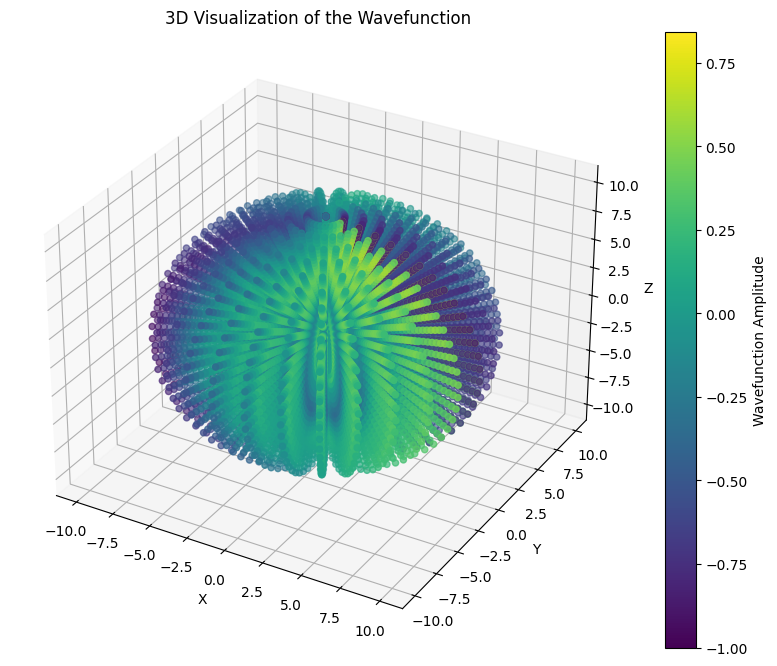

In [12]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Neural Network for the Wavefunction Approximation
class SchrodingerNet(nn.Module):
    def __init__(self):
        super(SchrodingerNet, self).__init__()
        self.fc1 = nn.Linear(3, 128)  # Input: r, theta, phi
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)  # Output: psi(r, theta, phi)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the Hamiltonian Operator
def hamiltonian_operator(model, r, theta, phi, hbar=1.0, mu=1.0, e=1.0, epsilon_0=1.0):
    # Convert coordinates to require gradients
    r.requires_grad_(True)
    theta.requires_grad_(True)
    phi.requires_grad_(True)

    # Combine r, theta, and phi into a tensor
    coords = torch.stack([r, theta, phi], dim=1)

    # Predict the wavefunction using the neural network
    psi = model(coords)

    # Calculate the derivatives using autograd
    psi_r = autograd.grad(psi, r, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    psi_rr = autograd.grad(psi_r, r, grad_outputs=torch.ones_like(psi_r), create_graph=True)[0]
    psi_theta = autograd.grad(psi, theta, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    psi_theta_theta = autograd.grad(psi_theta, theta, grad_outputs=torch.ones_like(psi_theta), create_graph=True)[0]
    psi_phi = autograd.grad(psi, phi, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    psi_phi_phi = autograd.grad(psi_phi, phi, grad_outputs=torch.ones_like(psi_phi), create_graph=True)[0]

    # Compute the terms of the Hamiltonian
    radial_term = -(hbar**2 / (2 * mu)) * (1 / r**2) * (r**2 * psi_rr)
    angular_theta_term = -(hbar**2 / (2 * mu)) * (1 / (r**2 * torch.sin(theta))) * (torch.sin(theta) * psi_theta_theta)
    angular_phi_term = -(hbar**2 / (2 * mu)) * (1 / (r**2 * torch.sin(theta)**2)) * psi_phi_phi
    potential_term = - e**2 / (4 * torch.pi * epsilon_0 * r)

    # Total Hamiltonian applied to the wavefunction
    hamiltonian_psi = radial_term + angular_theta_term + angular_phi_term + potential_term * psi
    return hamiltonian_psi

# Loss Function
def loss_function(model, r, theta, phi, E):
    hamiltonian_psi = hamiltonian_operator(model, r, theta, phi)
    coords = torch.stack([r, theta, phi], dim=1)
    psi_pred = model(coords)
    return torch.mean((hamiltonian_psi - E * psi_pred) ** 2)

# Function to sample spherical coordinates
def sample_coordinates(batch_size=100):
    r = torch.rand(batch_size) * 20.0  # r sampled from 0 to 20
    theta = torch.rand(batch_size) * torch.pi  # theta sampled from 0 to π
    phi = torch.rand(batch_size) * 2 * torch.pi  # phi sampled from 0 to 2π
    return r, theta, phi

# Training Loop
def train_model(model, eigenvalue, num_epochs=1000, learning_rate=0.001, batch_size=100):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        r, theta, phi = sample_coordinates(batch_size=batch_size)
        loss = loss_function(model, r, theta, phi, eigenvalue)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Function to convert spherical coordinates to Cartesian coordinates
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

# Generate a grid of spherical coordinates for visualization and extracting wavefunction
def generate_spherical_grid(num_points=30):
    r = torch.linspace(0.1, 10.0, num_points)
    theta = torch.linspace(0, torch.pi, num_points)
    phi = torch.linspace(0, 2 * torch.pi, num_points)
    r, theta, phi = torch.meshgrid(r, theta, phi, indexing='ij')
    return r, theta, phi

# Function to get and visualize the eigenfunction
def get_eigenfunction(model):
    r, theta, phi = generate_spherical_grid(num_points=30)
    coords = torch.stack([r.flatten(), theta.flatten(), phi.flatten()], dim=1)
    psi_pred = model(coords).detach().numpy()
    r_np = r.flatten().numpy()
    theta_np = theta.flatten().numpy()
    phi_np = phi.flatten().numpy()

    # Reshape the output for easier interpretation
    psi_pred = psi_pred.reshape(r.shape)

    # Convert to Cartesian coordinates for plotting
    x, y, z = spherical_to_cartesian(r_np, theta_np, phi_np)

    return r_np, theta_np, phi_np, psi_pred, x, y, z

# Plot the eigenfunction in 3D
def plot_wavefunction_3d(x, y, z, psi_pred):
    psi_pred_normalized = psi_pred / np.max(np.abs(psi_pred))
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=psi_pred_normalized.flatten(), cmap='viridis', marker='o')
    fig.colorbar(scatter, ax=ax, label='Wavefunction Amplitude')
    ax.set_title("3D Visualization of the Wavefunction")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Main function to input eigenvalue, get eigenfunction, and visualize it
def main():
    # Input eigenvalue for the hydrogen atom (in eV)
    eigenvalue = float(input("Enter the eigenvalue (in eV, e.g., -13.6 for ground state): "))

    # Initialize the model
    model = SchrodingerNet()

    # Train the model with the given eigenvalue
    train_model(model, eigenvalue=eigenvalue, num_epochs=1000, learning_rate=0.001, batch_size=100)

    # Get the predicted eigenfunction
    r_np, theta_np, phi_np, psi_pred, x, y, z = get_eigenfunction(model)

    # Visualize the eigenfunction in 3D
    plot_wavefunction_3d(x, y, z, psi_pred)

    # Return the eigenfunction data for further use
    return r_np, theta_np, phi_np, psi_pred

# Run the main function
if __name__ == "__main__":
    eigenfunction_data = main()
